In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import roc_auc_score, classification_report, roc_curve, accuracy_score, f1_score
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

In [ ]:
def load_and_preprocess_data():
    # Load and process
    data = pd.read_csv("clean.csv")
    X = data.drop(columns=["Response", "ID", "Unnamed: 0"])
    y = data["Response"]

    # Encode
    categorical_cols = [
        'Reco_Policy_Cat', 'City_Code', 'Region_Code',
        'Reco_Insurance_Type', 'Accomodation_Type',
        'Health_Indicator', 'Holding_Policy_Type', 'Is_Spouse'
    ]

    label_encoders = {}
    for col in categorical_cols:
        if col in X.columns:
            le = LabelEncoder()
            X[col] = le.fit_transform(X[col].astype(str))
            label_encoders[col] = le

    # Normalize
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    return X_scaled, y, scaler, label_encoders

In [ ]:
# Feature Engineering
def create_features_for_bnn(X_train, X_test, y_train):
    train_data = pd.DataFrame(X_train)
    test_data = pd.DataFrame(X_test)

    train_data['target'] = y_train.values

    # Feature interaction
    train_data['age_premium_interaction'] = train_data[0] * train_data[1]
    test_data['age_premium_interaction'] = test_data[0] * test_data[1]

    train_data['age_duration_interaction'] = train_data[0] * train_data[2]
    test_data['age_duration_interaction'] = test_data[0] * test_data[2]

    train_data['age_squared'] = train_data[0] ** 2
    test_data['age_squared'] = test_data[0] ** 2

    train_data['premium_squared'] = train_data[1] ** 2
    test_data['premium_squared'] = test_data[1] ** 2

    train_data['premium_age_ratio'] = train_data[1] / (train_data[0] + 1e-5)
    test_data['premium_age_ratio'] = test_data[1] / (test_data[0] + 1e-5)


    X_train_enhanced = train_data.drop(columns=['target']).values
    X_test_enhanced = test_data.values

    return X_train_enhanced, X_test_enhanced

In [ ]:
# Evaluation
def evaluate_model(model, X_test, y_test, stage_name):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    fpr,tpr,thresholds = roc_curve(y_test, y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"\n{'='*50}")
    print(f"{stage_name} Stage Result")
    print(f"{'='*50}")
    print(f"ROC AUC: {auc:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    return {
        'fpr':fpr,
        'tpr':tpr,
        'auc': auc,
        'accuracy': accuracy,
        'f1': f1,
        'y_pred_proba': y_pred_proba,
        'model': model
    }

### Base

In [ ]:
### Base
def train_base_bnn(X_train, X_test, y_train, y_test):
    print("Base BNN Training...")

    model = MLPClassifier(
        hidden_layer_sizes=(100, 50),
        activation='relu',
        solver='adam',
        random_state=42,
        max_iter=300,
        early_stopping=True,
        validation_fraction=0.1
    )

    model.fit(X_train, y_train)
    return evaluate_model(model, X_test, y_test, "Base BNN")

### SMOTE

In [ ]:
def train_bnn_with_smote(X_train, X_test, y_train, y_test):
    print("BNN + SMOTE...")

    smote = SMOTE(random_state=42)
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

    model = MLPClassifier(
        hidden_layer_sizes=(100, 50),
        activation='relu',
        solver='adam',
        random_state=42,
        max_iter=300,
        early_stopping=True,
        validation_fraction=0.1
    )

    model.fit(X_train_smote, y_train_smote)
    return evaluate_model(model, X_test, y_test, "BNN + SMOTE")

### Hyperparameter Tuning

In [ ]:
def train_bnn_with_hyperparameter_tuning(X_train, X_test, y_train, y_test):
    print("BNN + Hyperparameter Tuning...")

    param_grid = {
        'hidden_layer_sizes': [(50,), (100,), (100, 50), (150, 100)],
        'activation': ['relu', 'tanh'],
        'alpha': [0.0001, 0.001, 0.01],
        'learning_rate_init': [0.001, 0.01, 0.1]
    }

    model = MLPClassifier(
        solver='adam',
        random_state=42,
        max_iter=300,
        early_stopping=True,
        validation_fraction=0.1
    )

    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring='roc_auc',
        cv=3,
        n_jobs=1,
        verbose=100
    )

    grid_search.fit(X_train, y_train)

    print(f"Best params: {grid_search.best_params_}")
    print(f"Best cross validation score: {grid_search.best_score_:.4f}")

    best_model = grid_search.best_estimator_
    return evaluate_model(best_model, X_test, y_test, "BNN + Hyperparameter Tuning")

### Feature Engineering

In [ ]:
def train_bnn_with_feature_engineering(X_train, X_test, y_train, y_test):
    print("BNN + Feature Engineering...")

    X_train_fe, X_test_fe = create_features_for_bnn(X_train, X_test, y_train)

    # Normalize
    scaler_fe = StandardScaler()
    X_train_fe_scaled = scaler_fe.fit_transform(X_train_fe)
    X_test_fe_scaled = scaler_fe.transform(X_test_fe)

    model = MLPClassifier(
        hidden_layer_sizes=(100, 50),
        activation='relu',
        solver='adam',
        random_state=42,
        max_iter=300,
        early_stopping=True,
        validation_fraction=0.1
    )

    model.fit(X_train_fe_scaled, y_train)
    return evaluate_model(model, X_test_fe_scaled, y_test, "BNN + Feature Engineering")

In [3]:
def main():
    X, y, scaler, label_encoders = load_and_preprocess_data()

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    results = {}


    results['base'] = train_base_bnn(X_train, X_test, y_train, y_test)
    results['smote'] = train_bnn_with_smote(X_train, X_test, y_train, y_test)
    results['tuning'] = train_bnn_with_hyperparameter_tuning(X_train, X_test, y_train, y_test)
    results['feature_engineering'] = train_bnn_with_feature_engineering(X_train, X_test, y_train, y_test)

    comparison = pd.DataFrame({
        'Stage': ['Base BNN', 'BNN + SMOTE', 'BNN + Tuning', 'BNN + Feature Engineering'],
        'ROC AUC': [
            results['base']['auc'],
            results['smote']['auc'],
            results['tuning']['auc'],
            results['feature_engineering']['auc']
        ],
        'Accuracy': [
            results['base']['accuracy'],
            results['smote']['accuracy'],
            results['tuning']['accuracy'],
            results['feature_engineering']['accuracy']
        ],
        'F1 Score': [
            results['base']['f1'],
            results['smote']['f1'],
            results['tuning']['f1'],
            results['feature_engineering']['f1']
        ]
    })

    print(comparison.to_string(index=False))

    return results

if __name__ == "__main__":
    results = main()

Base BNN Training...

Base BNN Stage Result
ROC AUC: 0.5347
Accuracy: 0.7600
F1 Score: 0.0000

Classification Report:
              precision    recall  f1-score   support

           0       0.76      1.00      0.86      7735
           1       0.00      0.00      0.00      2442

    accuracy                           0.76     10177
   macro avg       0.38      0.50      0.43     10177
weighted avg       0.58      0.76      0.66     10177

BNN + SMOTE...

BNN + SMOTE Stage Result
ROC AUC: 0.5624
Accuracy: 0.5612
F1 Score: 0.3495

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.58      0.67      7735
           1       0.27      0.49      0.35      2442

    accuracy                           0.56     10177
   macro avg       0.53      0.54      0.51     10177
weighted avg       0.66      0.56      0.59     10177

BNN + Hyperparameter Tuning...
Fitting 3 folds for each of 72 candidates, totalling 216 fits
[CV 1/3; 1/72] START

In [4]:
fpr_base=results['base']['fpr']
tpr_base=results['base']['tpr']
auc_base=results['base']['auc']

fpr_sm=results['smote']['fpr']
tpr_sm=results['smote']['tpr']
auc_sm=results['smote']['auc']

fpr_tuned=results['tuning']['fpr']
tpr_tuned=results['tuning']['tpr']
auc_tuned=results['tuning']['auc']

fpr_fe=results['feature_engineering']['fpr']
tpr_fe=results['feature_engineering']['tpr']
auc_fe=results['feature_engineering']['auc']

### Tuning plot

In [6]:
def plot_tuning_trend(grid_search):

    results = grid_search.cv_results_

    plt.figure(figsize=(12, 6))

    plt.plot(range(len(results['params'])), results['mean_test_score'],
            'o-', linewidth=2, markersize=8, color='blue', label='Mean AUC')

    plt.fill_between(range(len(results['params'])),
                    results['mean_test_score'] - results['std_test_score'],
                    results['mean_test_score'] + results['std_test_score'],
                    alpha=0.2, color='blue', label='±1 std')
    best_idx = np.argmax(results['mean_test_score'])
    plt.plot(best_idx, results['mean_test_score'][best_idx], 'ro',
            markersize=12, label='Best Combination')

    plt.xlabel('Parameter Combination Index', fontsize=12)
    plt.ylabel('AUC Score', fontsize=12)
    plt.title('Hyperparameter Tuning Performance Trend', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend()

    plt.annotate(f'Best: {results["mean_test_score"][best_idx]:.4f}',
                xy=(best_idx, results['mean_test_score'][best_idx]),
                xytext=(best_idx+2, results['mean_test_score'][best_idx]-0.02),
                arrowprops=dict(arrowstyle='->', color='red'),
                fontsize=10, color='red')

    plt.tight_layout()
    plt.show()

Base BNN Training...

Base BNN Stage Result
ROC AUC: 0.5347
Accuracy: 0.7600
F1 Score: 0.0000

Classification Report:
              precision    recall  f1-score   support

           0       0.76      1.00      0.86      7735
           1       0.00      0.00      0.00      2442

    accuracy                           0.76     10177
   macro avg       0.38      0.50      0.43     10177
weighted avg       0.58      0.76      0.66     10177

BNN + SMOTE...

BNN + SMOTE Stage Result
ROC AUC: 0.5624
Accuracy: 0.5612
F1 Score: 0.3495

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.58      0.67      7735
           1       0.27      0.49      0.35      2442

    accuracy                           0.56     10177
   macro avg       0.53      0.54      0.51     10177
weighted avg       0.66      0.56      0.59     10177

============================== Baseline BNN+Tuned ==============================
Fitting 3 folds for each of 72 c

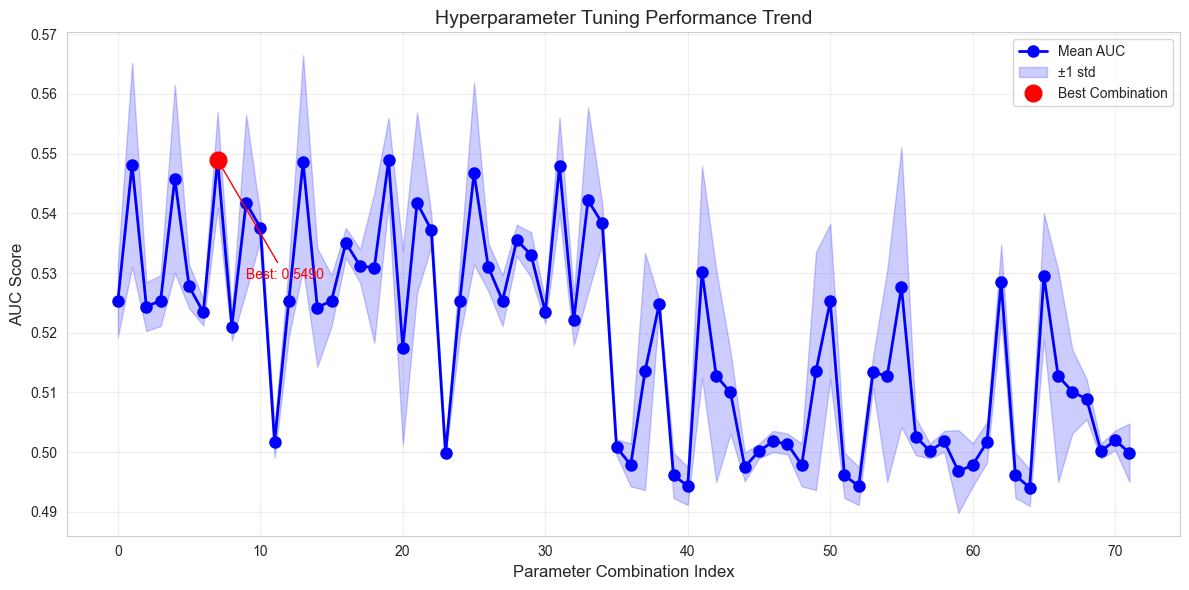


BNN + Hyperparameter Tuning Stage Result
ROC AUC: 0.5518
Accuracy: 0.7600
F1 Score: 0.0000

Classification Report:
              precision    recall  f1-score   support

           0       0.76      1.00      0.86      7735
           1       0.00      0.00      0.00      2442

    accuracy                           0.76     10177
   macro avg       0.38      0.50      0.43     10177
weighted avg       0.58      0.76      0.66     10177

BNN + Feature Engineering...

BNN + Feature Engineering Stage Result
ROC AUC: 0.5607
Accuracy: 0.7599
F1 Score: 0.0008

Classification Report:
              precision    recall  f1-score   support

           0       0.76      1.00      0.86      7735
           1       0.25      0.00      0.00      2442

    accuracy                           0.76     10177
   macro avg       0.51      0.50      0.43     10177
weighted avg       0.64      0.76      0.66     10177

                    Stage  ROC AUC  Accuracy  F1 Score
                 Base BNN 0.5346

In [7]:
def train_bnn_with_hyperparameter_tuning(X_train, X_test, y_train, y_test):
    print("="*30,"Baseline BNN+Tuned","="*30)

    param_grid = {
        'hidden_layer_sizes': [(50,), (100,), (100, 50), (150, 100)],
        'activation': ['relu', 'tanh'],
        'alpha': [0.0001, 0.001, 0.01],
        'learning_rate_init': [0.001, 0.01, 0.1]
    }

    model = MLPClassifier(
        solver='adam',
        random_state=42,
        max_iter=300,
        early_stopping=True,
        validation_fraction=0.1
    )

    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring='roc_auc',
        cv=3,
        n_jobs=1,
        verbose=100
    )

    grid_search.fit(X_train, y_train)

    print(f"Best params: {grid_search.best_params_}")
    print(f"Best cross validation score: {grid_search.best_score_:.4f}")

    plot_tuning_trend(grid_search)

    best_model = grid_search.best_estimator_
    return evaluate_model(best_model, X_test, y_test, "BNN + Hyperparameter Tuning")

if __name__ == "__main__":
    results = main()

### ROC

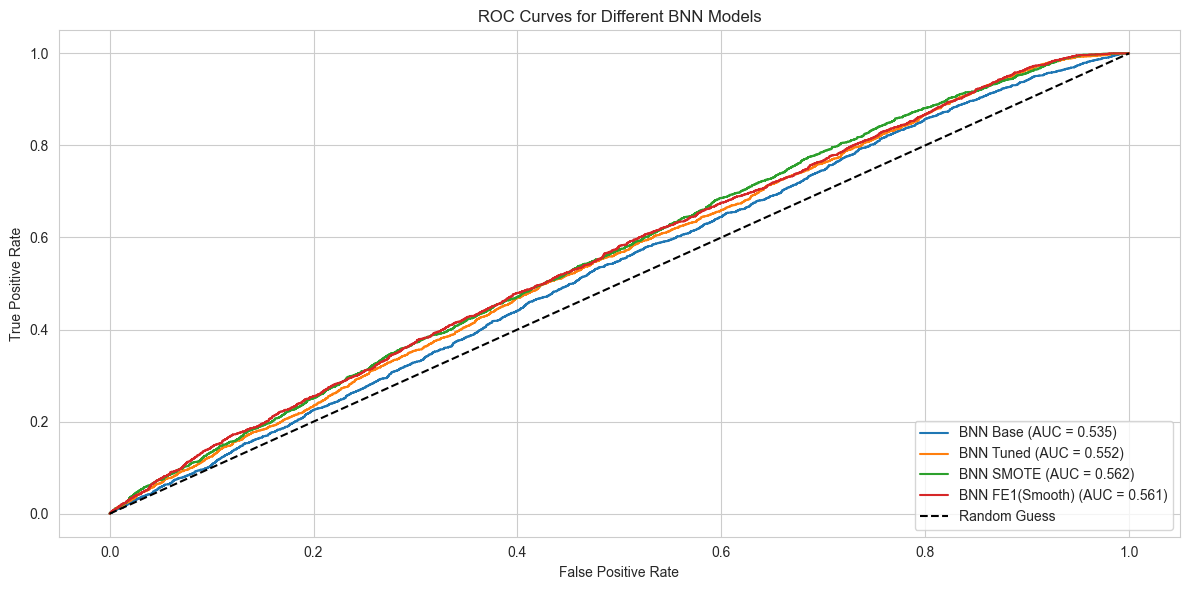

In [5]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))

plt.plot(fpr_base,  tpr_base,  label=f"BNN Base (AUC = {auc_base:.3f})")
plt.plot(fpr_tuned,  tpr_tuned,  label=f"BNN Tuned (AUC = {auc_tuned:.3f})")
plt.plot(fpr_sm,  tpr_sm,  label=f"BNN SMOTE (AUC = {auc_sm:.3f})")
plt.plot(fpr_fe,  tpr_fe,  label=f"BNN FE1(Smooth) (AUC = {auc_fe:.3f})")

plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Different BNN Models')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()